In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps():
    device = 'mps'
device

'cuda'

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c = 'b', s= 4, label = 'Training Data')
    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Testing Data')
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s=4, label = "Prediction")
    plt.legend(prop={'size': 14})
    plt.show()

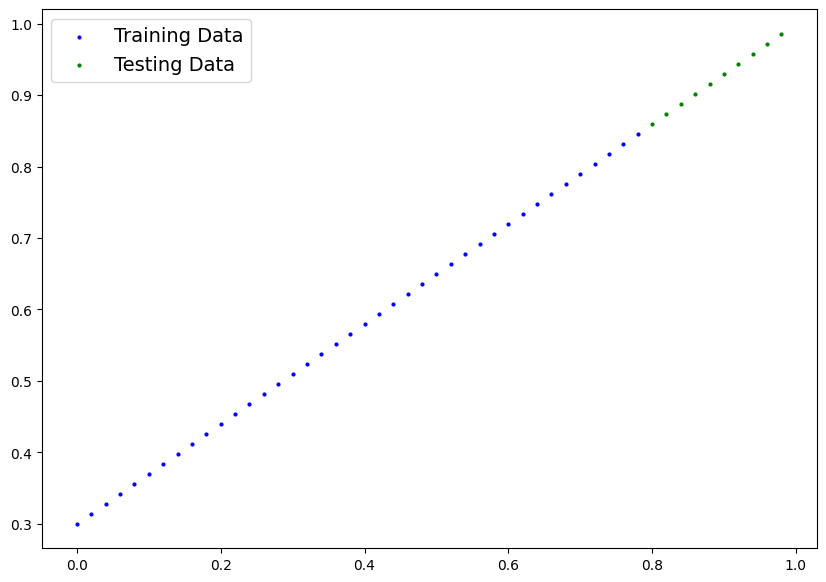

In [6]:
plot_predictions(X_train, y_train, X_test, y_test)

In [7]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X.unsqueeze(1), y.unsqueeze(1), test_size=0.2, random_state=42)
# plot_predictions(X_train, y_train, X_test, y_test)

In [8]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [9]:
next(model_1.parameters()).device

device(type='cpu')

In [10]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [12]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [13]:
torch.manual_seed(42)
epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)

y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss= loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Tets loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Tets loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Tets loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Tets loss: 0.013801801018416882


In [14]:
from pprint import pprint
pprint("The model learned the following values for weights and bias: ")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

'The model learned the following values for weights and bias: '
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [17]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

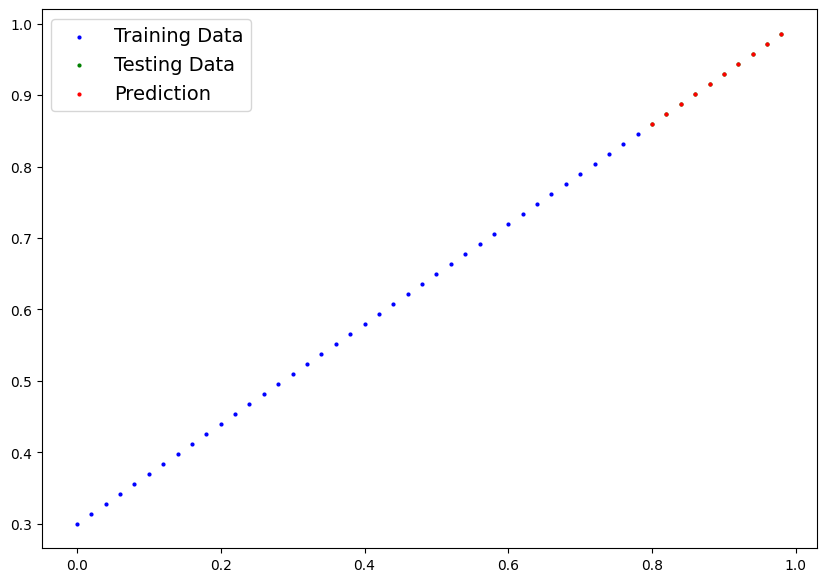

In [19]:
plot_predictions(predictions=y_preds.cpu())

In [20]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [21]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


/tmp/ipykernel_175293/3749376162.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [22]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')